In [56]:
# Noah Venethongkham, 219660117
# Ashley Thor, 219334909
# Lucas Saechao, 218794239
# CSC 180 - Intelligent Systems

In [23]:
# matplotlib
%matplotlib inline
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt

# numpy and pandas
import numpy as np
import pandas as pd

# scikit learn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d
import sklearn.feature_extraction.text as sk_text
import skimage.transform

# natural language toolkit
# run pip install nltk
from nltk.corpus import stopwords
import nltk

# tensorflow and keras
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, Embedding
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# run pip install np_utils
from tensorflow.keras.utils import to_categorical

# python libraries
from collections.abc import Sequence
import requests
import pathlib
import shutil
import json
import time
import csv
import io
import os

# if OS is windows, import chime
if os.name == 'nt':
    import winsound

In [24]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plots a confusion matrix for the model
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot an ROC curve
def plot_roc(pred, y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_area_under_curve = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = $0.2f)' % roc_area_under_curve)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show
    
def remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    whitelist = ["n't", "not", "no"]
    words = text.split()
    words_clean = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(words_clean)
    
# Beep if on a windows machine
if os.name == 'nt':
    def ding():
        winsound.Beep(2000, 300)
        winsound.Beep(2000, 300)
        winsound.Beep(2000, 300)

In [59]:
def deep_model(model, x_train, y_train, x_test, y_test):
    model.compile(
        optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        x_train,
        y_train,
        epochs=10,
        batch_size=512,
        validation_data=(x_test, y_test),
        verbose=0
    )
    return history

def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, 11)
    
    plt.plot(e, metric, 'bo', label="Train " + metric_name)
    plt.plot(e, val_metric, 'b', label="Validation " + metric_name)
    plt.legend()
    plt.show()
    
def test_model(model, x_train, y_train, x_test, y_test, epoch):
    model.fit(x_train, y_train, epochs=epoch, batch_size=512, verbose=0)
    results = model.evaluate(x_test, y_test)
    return results

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\19165\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
# Create pandas dataframe output file
df_reddit = pd.read_csv('reddit_vm.csv', encoding="utf-8")
df_reddit = df_reddit.reindex(np.random.permutation(df_reddit.index))
df_reddit = df_reddit[['title', 'body', 'score']].fillna('')
df_reddit['title'] = df_reddit['title'].replace(to_replace='Comment', value='')

print(df_reddit)

                                                  title  \
1047                                                      
342   Use of a youtube video to try to prove the pol...   
1293                                                      
548                                                       
431   The most common injury I have seen is vaccine ...   
...                                                 ...   
768                                                       
191            Can we please spill the tea on vaccines?   
1151                                                      
292   Antivax book "Dissolving Illusions" - 2 negati...   
1297                                                      

                                                   body  score  
1047  Desktop link: https://en.wikipedia.org/wiki/Et...      2  
342                                                          8  
1293  I'm a bot, *bleep*, *bloop*. Someone has linke...      1  
548   You keep using words but 

In [27]:
df_reddit.body = df_reddit.body.apply(remove_stopwords)
print(df_reddit)

                                                  title  \
1047                                                      
342   Use of a youtube video to try to prove the pol...   
1293                                                      
548                                                       
431   The most common injury I have seen is vaccine ...   
...                                                 ...   
768                                                       
191            Can we please spill the tea on vaccines?   
1151                                                      
292   Antivax book "Dissolving Illusions" - 2 negati...   
1297                                                      

                                                   body  score  
1047  Desktop link: https://en.wikipedia.org/wiki/Et...      2  
342                                                          8  
1293  I'm bot, *bleep*, *bloop*. Someone linked thre...      1  
548               You keep usin

In [28]:
x_train, x_test, y_train, y_test = train_test_split(df_reddit.body, df_reddit.score, test_size=0.1, random_state=37)
print('# Train data samples:', x_train.shape[0])
print('# Test data samples:', x_test.shape[0])
assert x_train.shape[0] == y_train.shape[0]
assert y_test.shape[0] == y_test.shape[0]

# Train data samples: 1341
# Test data samples: 150


In [29]:
tokens = Tokenizer(
    num_words=10000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" "
)
tokens.fit_on_texts(x_train)
x_train_seq = tokens.texts_to_sequences(x_train)
x_test_seq = tokens.texts_to_sequences(x_test)

In [30]:
seq_lengths = x_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    1341.000000
mean       27.597315
std        68.267016
min         1.000000
25%         1.000000
50%         8.000000
75%        24.000000
max       819.000000
Name: body, dtype: float64

In [31]:
x_train_seq_trunc = pad_sequences(x_train_seq, maxlen=819)
x_test_seq_trunc = pad_sequences(x_test_seq, maxlen=819)

In [32]:
x_train_seq_trunc[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [33]:
labeler = LabelEncoder()
y_train_label = labeler.fit_transform(y_train)
y_test_label = labeler.fit_transform(y_test)
y_train_cat = to_categorical(y_train_label)
y_test_cat = to_categorical(y_test_label)

In [68]:
x_train_emb, x_valid_emb, y_train_emb, y_valid_emb = train_test_split(x_train_seq_trunc, y_train_cat, test_size=0.1, random_state=37)
assert x_train_emb.shape[0] == y_train_emb.shape[0]
assert x_valid_emb.shape[0] == y_valid_emb.shape[0]

print("X train shape: {}".format(x_train_emb.shape))
print("X valid shape: {}".format(x_valid_emb.shape))

X train shape: (1206, 819)
X valid shape: (135, 819)


In [40]:
emb_model = Sequential()
emb_model.add(Embedding(10000, 8, input_length=819))
emb_model.add(Flatten())
emb_model.add(Dense(41, activation='softmax'))
emb_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 819, 8)            80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6552)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                268673    
Total params: 348,673
Trainable params: 348,673
Non-trainable params: 0
_________________________________________________________________


In [42]:
emb_history = deep_model(emb_model, x_train_emb, y_train_emb, x_valid_emb, y_valid_emb)
emb_history.history['accuracy'][-1]

0.41293532

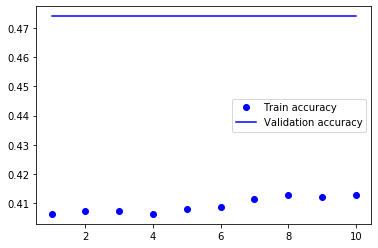

In [49]:
eval_metric(emb_history, 'accuracy')

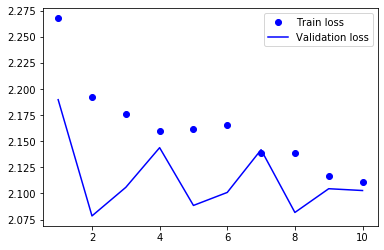

In [50]:
eval_metric(emb_history, 'loss')

In [53]:
glove_file = os.path.join(
    os.path.expanduser("~"), ".keras/datasets/glove.6B.300d.txt"
)

emb_dict = {}
glove = open(glove_file, encoding='utf-8')
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

print("Found {} word vectors".format(len(emb_dict)))

Found 400000 word vectors


In [54]:
covid = ['covid', 'virus', 'disease', 'sick', 'sickness', 'flu', 'vaccine']
for w in covid:
    if w in emb_dict.keys():
        print("Found {} in keys".format(w))

Found virus in keys
Found disease in keys
Found sick in keys
Found sickness in keys
Found flu in keys
Found vaccine in keys


In [56]:
emb_matrix = np.zeros((10000, 300))

for w, i in tokens.word_index.items():
    if i < 10000:
        vect = emb_dict.get(w)
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [58]:
glove_model = Sequential()
glove_model.add(Embedding(10000, 300, input_length=819))
glove_model.add(Flatten())
glove_model.add(Dense(41, activation='softmax'))
glove_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 819, 300)          3000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 245700)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 41)                10073741  
Total params: 13,073,741
Trainable params: 13,073,741
Non-trainable params: 0
_________________________________________________________________


In [60]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

In [61]:
glove_history = deep_model(glove_model, x_train_emb, y_train_emb, x_valid_emb, y_valid_emb)
glove_history.history['accuracy'][-1]

0.6791045

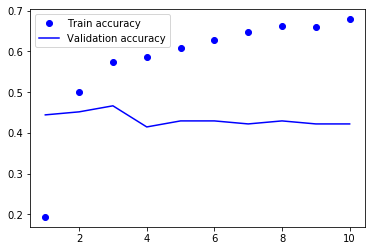

In [63]:
eval_metric(glove_history, 'accuracy')

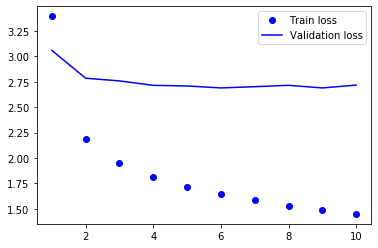

In [64]:
eval_metric(glove_history, 'loss')

In [67]:
glove_results = test_model(glove_model, x_train_seq_trunc, y_train_cat, x_test_seq_trunc, y_test_cat, 3)
print("/n")
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))

ValueError: A target array with shape (150, 21) was passed for an output of shape (None, 41) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.